# Intro:

**Final Project:**

    Telecome Operator Interconnect would like to forecast their churn customers. If the customer is a churn customer they
    would like to offer promotional codes and special plan options in order to retain.
    
    services provided:
    -Landline communication. The telephone can be connected to several lines simultaneously.
    -Internet. The network can be set up via a telephone line (DSL, digital subscriber line) or through a fiber optic cable.
       
       
    Some other services the company provides include:
        -Internet security: antivirus software (DeviceProtection) and a malicious website blocker (OnlineSecurity)
        -A dedicated technical support line (TechSupport)
        -Cloud file storage and data backup (OnlineBackup)
        -TV streaming (StreamingTV) and a movie directory (StreamingMovies)
    
    The clients can choose either a monthly payment or sign a 1- or 2-year contract.
    They can use various payment methods and receive an electronic invoice after a transaction.
    
 **Data Description:**
 
     4 files were obtain from different sources to provide customer data
         -contract.csv — contract information Valid as of February 1, 2020
         -personal.csv — the client's personal data
         -internet.csv — information about Internet services
         -phone.csv — information about telephone services
        In each file, the column customerID contains a unique code assigned to each client.

**Goal:** Develop a model to predict user churn

# Data Preprocessing

In [1]:
#import libraries that I may need for project
import pandas as pd
import numpy as np
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose

#visualization libraries
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots

#sklearn
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, accuracy_score, ConfusionMatrixDisplay, auc, roc_curve
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.utils import shuffle, resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample

#gradient boosting
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

#turn off warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#load data
df_contract = pd.read_csv("contract.csv")
df_personal = pd.read_csv("personal.csv")
df_internet = pd.read_csv("internet.csv")
df_phone = pd.read_csv("phone.csv")

In [3]:
df_contract['BeginDate'].value_counts().sort_values(ascending=False)

2014-02-01    366
2019-09-01    237
2019-11-01    237
2019-10-01    237
2020-01-01    233
             ... 
2020-02-01     11
2014-01-01      7
2013-12-01      3
2013-10-01      3
2013-11-01      2
Name: BeginDate, Length: 77, dtype: int64

In [4]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [5]:
df_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [6]:
df_personal['customerID'].value_counts()

2625-TRCZQ    1
6108-OQZDQ    1
0621-TSSMU    1
3540-RZJYU    1
1421-HCERK    1
             ..
2576-HXMPA    1
3389-YGYAI    1
4918-QLLIW    1
9578-VRMNM    1
6766-HFKLA    1
Name: customerID, Length: 7043, dtype: int64

In [7]:
df_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [8]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [9]:
df_phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [10]:
#merge all dataframes together

#merge contract and personal
df = df_contract.merge(df_personal, on= 'customerID')

#internet merge
df= df.merge(df_internet, how='outer', on= 'customerID')

#phone merge
df = df.merge(df_phone, how='outer', on = 'customerID')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


After merging all of the dataframes together, it left the new dataframe with missing values for the specific services that were not selected by certain members...
For the moment, I will fill the missing values with "not signed up".

In [11]:
#fill missing rows post-merge
df = df.fillna('Not signed up for other services')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   7043 non-null   object 
 13  OnlineSecurity    7043 non-null   object 
 14  OnlineBackup      7043 non-null   object 
 15  DeviceProtection  7043 non-null   object 
 16  TechSupport       7043 non-null   object 


In [12]:
#rename columns
df = df.rename(columns = {'customerID':'customer_id', 'BeginDate':'begin_date', 'EndDate':'end_date', 'Type':'type', 'PaperlessBilling':'paperless_billing', 'PaymentMethod':'payment_method', 'MonthlyCharges':'monthly_charges', 'TotalCharges':'total_charges', 'SeniorCitizen':'senior_citizen', 'Partner':'partner', 'Dependents':'dependents', 'InternetService':'internet_service', 'OnlineSecurity':'online_security', 'OnlineBackup':'online_backup', 'DeviceProtection':'device_protection', 'TechSupport':'tech_support', 'StreamingTV':'streaming_tv', 'StreamingMovies':'streaming_movies', 'MultipleLines':'multiple_lines'})

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  internet_service   7043 non-null   object 
 13  online_security    7043 non-null   object 
 14  online_backup      7043 non-null   object 
 15  device_protection  7043 non-null   object 
 16  tech_support       7043 

In [13]:
#change column data types

#convert 'begin_date' column to datetime 
df['begin_date'] = pd.to_datetime(df['begin_date'])

#convert 'total_charges' column to float64 
display((df['total_charges'] == ' ').sum()) #found 11 rows in the column with empty values. 
df['total_charges'].replace(" ", np.nan, inplace=True) #replace empty values with NaN to prepare to drop these rows
df = df.dropna(subset=['total_charges']) #drop 11 rows with NaN values in 'total_charges' column to convert to float64. 11 rows is much smaller than 5% of total data so its ok to drop these.
df['total_charges'] = df['total_charges'].astype('float64') #convert column to float64 

df.info()

11

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7032 non-null   object        
 1   begin_date         7032 non-null   datetime64[ns]
 2   end_date           7032 non-null   object        
 3   type               7032 non-null   object        
 4   paperless_billing  7032 non-null   object        
 5   payment_method     7032 non-null   object        
 6   monthly_charges    7032 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   gender             7032 non-null   object        
 9   senior_citizen     7032 non-null   int64         
 10  partner            7032 non-null   object        
 11  dependents         7032 non-null   object        
 12  internet_service   7032 non-null   object        
 13  online_security    7032 non-null   object        
 14  online_b

In [14]:
#dropping the customer Id column because it will not needed for the model.
df = df.drop('customer_id', axis=1)

In [15]:
df.head(25)

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,Not signed up for other services
1,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,Not signed up for other services
4,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
5,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.50,Female,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes
6,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,Male,0,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes
7,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.90,Female,0,No,No,DSL,Yes,No,No,No,No,No,Not signed up for other services
8,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05,Female,0,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes
9,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95,Male,0,No,Yes,DSL,Yes,Yes,No,No,No,No,No


# EDA

In [16]:
#create a new column based on 'end_date' to say if customer has left or not left the service which will serve as the target
df['customer_churn'] = np.where(df['end_date'] == 'No', 1, 0) # 1 is no churn, 0 is churn

#drop 'end_date' column
df = df.drop(['end_date'], axis=1)

df.head(20)

,begin_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,customer_churn
0,2020-01-01,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,Not signed up for other services,1
1,2017-04-01,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,1
2,2019-10-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,0
3,2016-05-01,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,Not signed up for other services,1
4,2019-09-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,0
5,2019-03-01,Month-to-month,Yes,Electronic check,99.65,820.50,Female,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes,0
6,2018-04-01,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,Male,0,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes,1
7,2019-04-01,Month-to-month,No,Mailed check,29.75,301.90,Female,0,No,No,DSL,Yes,No,No,No,No,No,Not signed up for other services,1
8,2017-07-01,Month-to-month,Yes,Electronic check,104.80,3046.05,Female,0,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes,0
9,2014-12-01,One year,No,Bank transfer (automatic),56.15,3487.95,Male,0,No,Yes,DSL,Yes,Yes,No,No,No,No,No,1


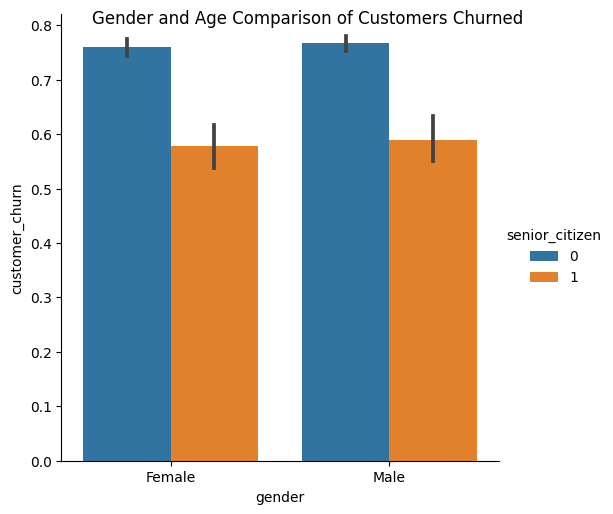

In [17]:
#visualize the churn of male-female customers and senior citizens
g = sns.catplot(data=df, x="gender", y="customer_churn", hue='senior_citizen', kind="bar")

g.fig.suptitle('Gender and Age Comparison of Customers Churned')
plt.show()

From the plot, it’s evident that while the male-to-female ratio of customers who churned is roughly equal, senior citizens represent a larger proportion of those who churned. We'll explore this further to determine whether senior citizens form a significant portion of the overall customer base.

internet_service                  customer_churn
DSL                               1                 1957
                                  0                  459
Fiber optic                       1                 1799
                                  0                 1297
Not signed up for other services  1                 1407
                                  0                  113
Name: customer_churn, dtype: int64

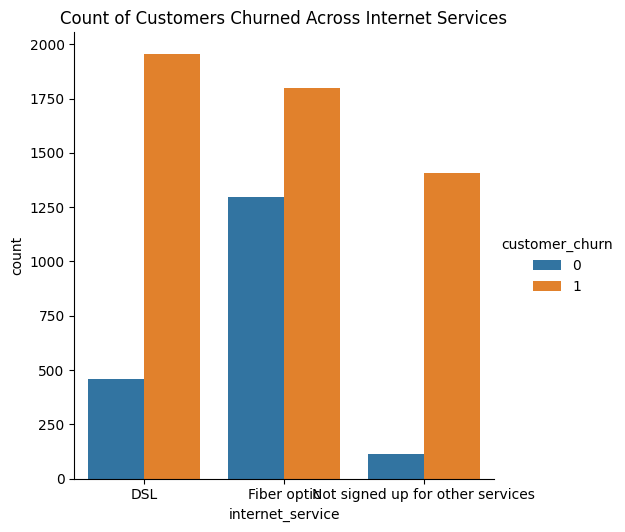

In [18]:
#visualize distribution of churned customers across internet services
int = df.groupby('internet_service')['customer_churn'].value_counts()
display(int)

sns.catplot(data=df, x='internet_service', hue='customer_churn', kind='count')
plt.title('Count of Customers Churned Across Internet Services')
plt.show()

Customers who subscribed to fiber optic internet service not only exhibited the highest percentage of churn within that category but also accounted for the largest number of churned customers across all three internet service types.

Percentage of customers in the dataframe that did not churn: 73.42150170648463


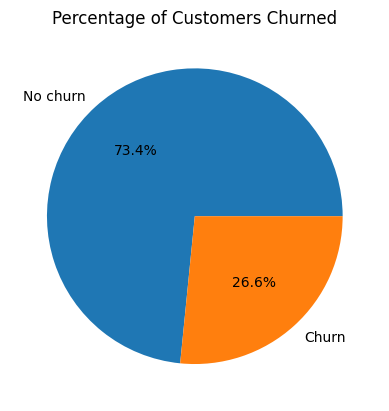

In [19]:

#checking for a class imbalance
classes = len(df[df['customer_churn'] == 1]) / len(df['customer_churn']) * 100
print('Percentage of customers in the dataframe that did not churn:', classes)

labels = ['No churn', 'Churn']
fig, ax = plt.subplots()
ax.pie(df['customer_churn'].value_counts(), labels=labels, autopct='%1.1f%%')
plt.title('Percentage of Customers Churned')
plt.show()

The chart above highlights a class imbalance in the target column, customer_churn. Specifically, the number of loyal customers significantly exceeds those who churned (represented by 0). This imbalance poses a challenge, as any model trained on such data may struggle to accurately predict churn for the minority class.

Solution: Upsampling. This technique involves generating additional synthetic data points for the minority class—in this case, customers who have churned—to balance the dataset and improve model performance

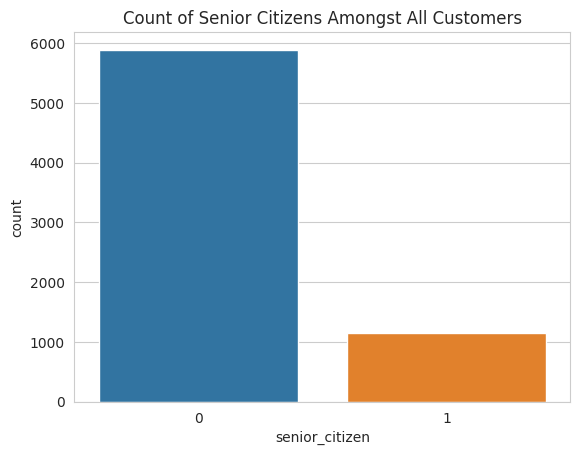

In [20]:
#countplot of senior citizens
sns.set_style('whitegrid')
sns.countplot(x='senior_citizen', data=df)
plt.title('Count of Senior Citizens Amongst All Customers')
plt.show()

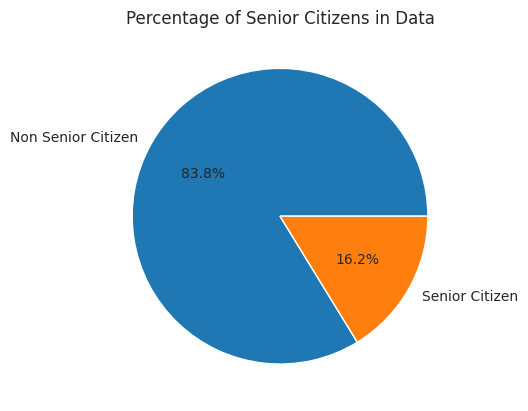

In [21]:
labels = ['Non Senior Citizen', 'Senior Citizen']
fig, ax = plt.subplots()
ax.pie(df['senior_citizen'].value_counts(), labels=labels, autopct='%1.1f%%')
plt.title('Percentage of Senior Citizens in Data')
plt.show()

The dataset shows that senior citizen customers number slightly over 1,100, comprising 16.2% of the total data.

Feat. Eng.

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7032 non-null   datetime64[ns]
 1   type               7032 non-null   object        
 2   paperless_billing  7032 non-null   object        
 3   payment_method     7032 non-null   object        
 4   monthly_charges    7032 non-null   float64       
 5   total_charges      7032 non-null   float64       
 6   gender             7032 non-null   object        
 7   senior_citizen     7032 non-null   int64         
 8   partner            7032 non-null   object        
 9   dependents         7032 non-null   object        
 10  internet_service   7032 non-null   object        
 11  online_security    7032 non-null   object        
 12  online_backup      7032 non-null   object        
 13  device_protection  7032 non-null   object        
 14  tech_sup

In [23]:
#create three features from the 'begin_date' column in order to gain more insight on data

#year
df['begin_year'] = df['begin_date'].dt.year

#month
df['begin_month'] = df['begin_date'].dt.month

#day of week
df['begin_day_of_week'] = df['begin_date'].dt.dayofweek

#drop 'begin_date' column from df
df = df.drop({'begin_date'}, axis=1) 

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7032 non-null   object 
 1   paperless_billing  7032 non-null   object 
 2   payment_method     7032 non-null   object 
 3   monthly_charges    7032 non-null   float64
 4   total_charges      7032 non-null   float64
 5   gender             7032 non-null   object 
 6   senior_citizen     7032 non-null   int64  
 7   partner            7032 non-null   object 
 8   dependents         7032 non-null   object 
 9   internet_service   7032 non-null   object 
 10  online_security    7032 non-null   object 
 11  online_backup      7032 non-null   object 
 12  device_protection  7032 non-null   object 
 13  tech_support       7032 non-null   object 
 14  streaming_tv       7032 non-null   object 
 15  streaming_movies   7032 non-null   object 
 16  multiple_lines     7032 

,begin_year,customer_churn,count
0,2013,0,8
1,2014,1,1246
2,2014,0,98
3,2015,1,729
4,2015,0,123
5,2016,1,618
6,2016,0,145
7,2017,1,646
8,2017,0,199
9,2018,1,715


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   begin_year      14 non-null     int64
 1   customer_churn  14 non-null     int64
 2   count           14 non-null     int64
dtypes: int64(3)
memory usage: 464.0 bytes


None

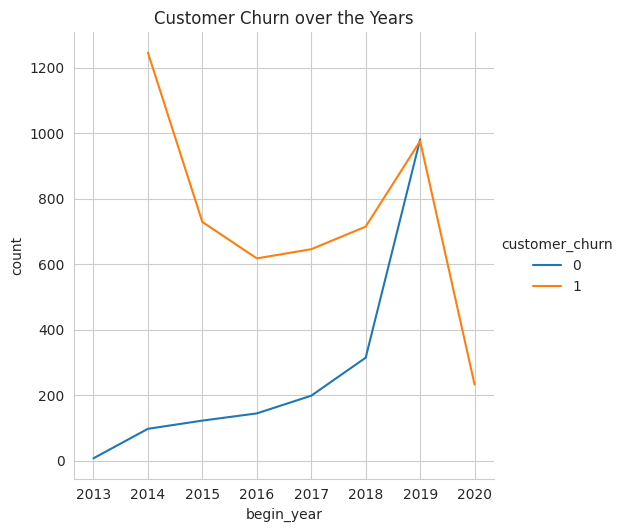

In [25]:
# Check 'begin_year' column for relationship to 'customer_churn'
year_df = (
    df.groupby('begin_year')['customer_churn']
    .value_counts()
    .rename('count')  # Rename the column to avoid conflicts
    .reset_index()
)

# Display the processed DataFrame and its info
display(year_df)
display(year_df.info())

# Plot the data
sns.relplot(data=year_df, x='begin_year', y='count', hue='customer_churn', kind='line')
plt.title('Customer Churn over the Years')
plt.show()

Starting in 2013, there is a noticeable increase in the total number of customers leaving Interconnect based on their start date. This trend may be linked to a potential service change in 2018 or 2019, as most current customers are longer-term subscribers. The start dates of 2018 and 2019 recorded the highest number of churned customers, with a significant portion of total churn occurring among customers who began their contracts in 2019.

The end date was not a key factor in this analysis, as the dataset included only four end dates for customers who churned, each occurring with nearly equal frequency.

,begin_month,customer_churn,count
0,1,1,529
1,1,0,94
2,2,1,671
3,2,0,122
4,3,1,483
5,3,0,107
6,4,1,413
7,4,0,98
8,5,1,368
9,5,0,126


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   begin_month     24 non-null     int64
 1   customer_churn  24 non-null     int64
 2   count           24 non-null     int64
dtypes: int64(3)
memory usage: 704.0 bytes


None

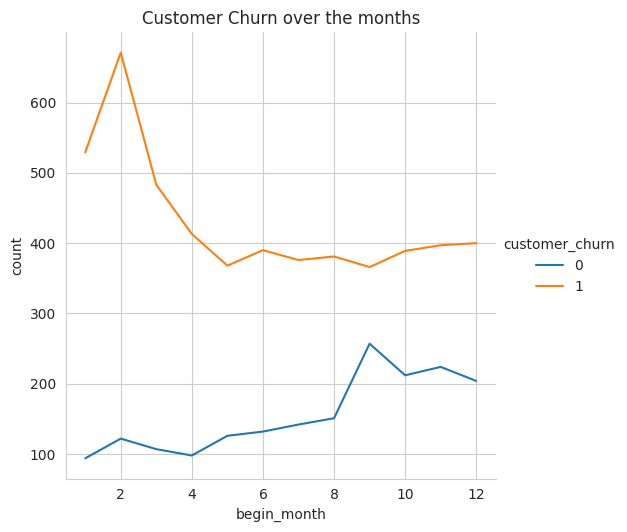

In [26]:
#check 'begin_month' column for relationship to 'customer churn'
month_df = (
    df.groupby('begin_month')['customer_churn']
    .value_counts()
    .rename('count')  # Rename the column to avoid conflicts
    .reset_index()
)

# Display the processed DataFrame and its info
display(month_df)
display(month_df.info())

# Plot the data
sns.relplot(data=month_df, x='begin_month', y='count', hue='customer_churn', kind='line')
plt.title('Customer Churn over the months')
plt.show()


A significant number of customers who churned had started their contracts in the fourth quarter of the year, particularly in September and the later months.

,begin_day_of_week,customer_churn,count
0,0,1,617
1,0,0,230
2,1,1,672
3,1,0,276
4,2,1,783
5,2,0,180
6,3,1,654
7,3,0,219
8,4,1,723
9,4,0,345


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   begin_day_of_week  14 non-null     int64
 1   customer_churn     14 non-null     int64
 2   count              14 non-null     int64
dtypes: int64(3)
memory usage: 464.0 bytes


None

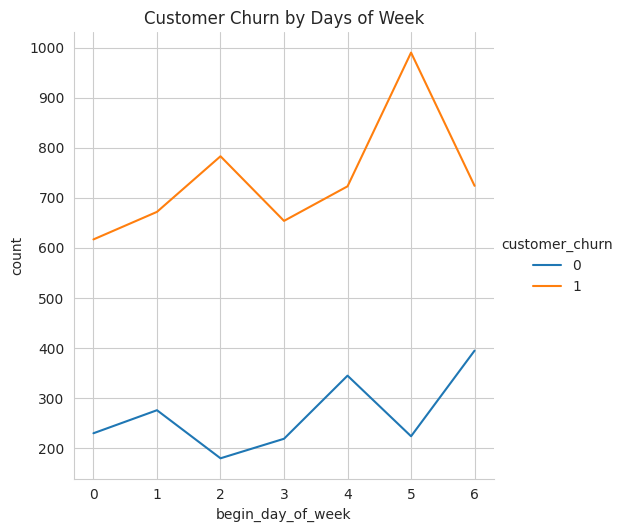

In [27]:
#check 'begin_day_of_week' column for relationship to 'customer churn'
day_df = (
    df.groupby('begin_day_of_week')['customer_churn']
    .value_counts()
    .rename('count')  # Rename the column to avoid conflicts
    .reset_index()
)

# Display the processed DataFrame and its info
display(day_df)
display(day_df.info())

# Plot the data
sns.relplot(data=day_df, x='begin_day_of_week', y='count', hue='customer_churn', kind='line')
plt.title('Customer Churn by Days of Week')
plt.show()


The majority of customers who are no longer under contract with Interconnect began their service on Thursdays and Saturdays, during the months of September to December, and in the years 2018 and 2019.

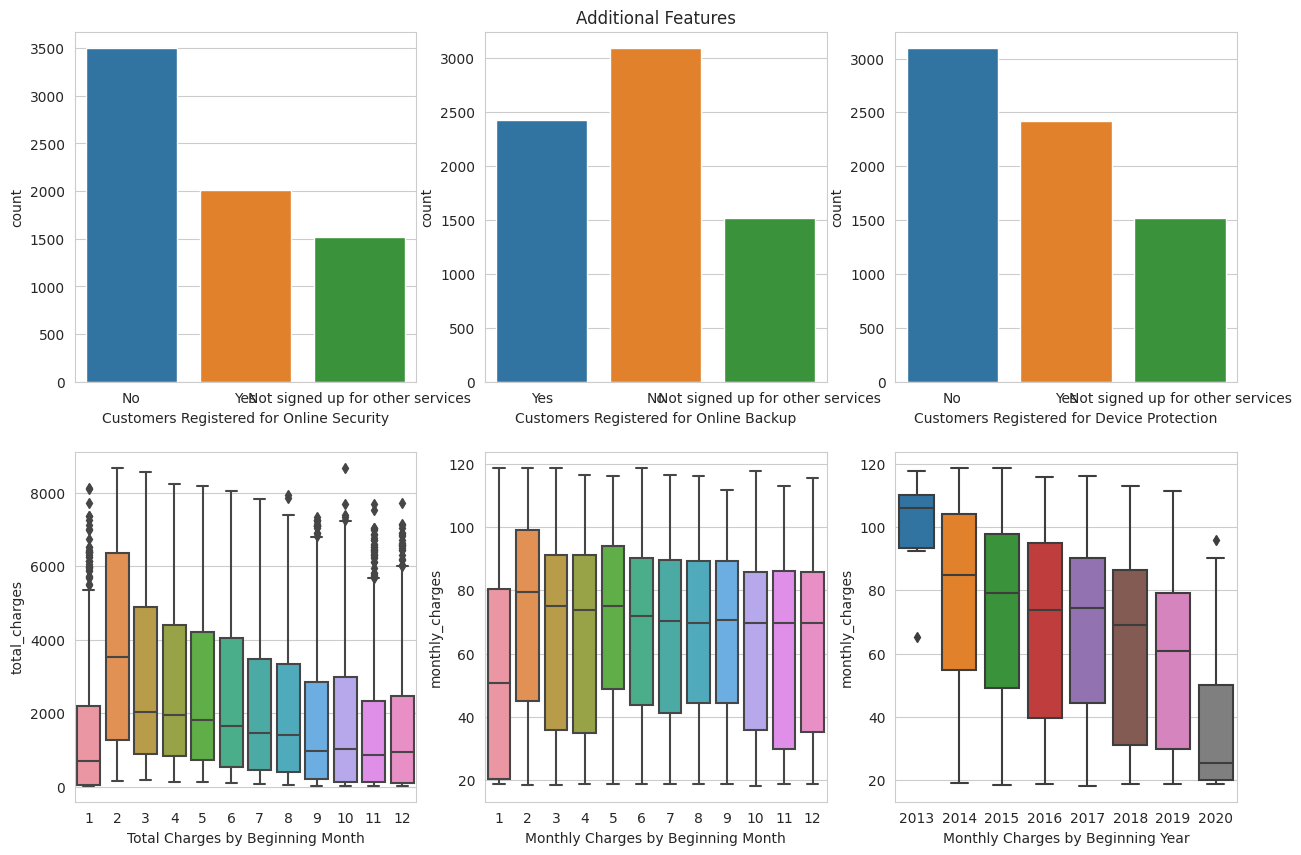

In [28]:
#Analyzing additional features
fig = plt.figure(figsize = (15, 10))

ax1 = fig.add_subplot(2,3,1)
sns.countplot(data=df, x='online_security', ax=ax1)
plt.xlabel('Customers Registered for Online Security')

ax2 = fig.add_subplot(2,3,2)
plt.title('Additional Features')
sns.countplot(data=df, x='online_backup', ax=ax2)
plt.xlabel('Customers Registered for Online Backup')

ax3 = fig.add_subplot(2,3,3)
sns.countplot(data=df, x='device_protection', ax=ax3)
plt.xlabel('Customers Registered for Device Protection')

ax4 = fig.add_subplot(2,3,4)
sns.boxplot(data=df, x='begin_month', y='total_charges', ax=ax4)
plt.xlabel('Total Charges by Beginning Month')

ax5 = fig.add_subplot(2,3,5)
sns.boxplot(data=df, x='begin_month', y='monthly_charges', ax=ax5)
plt.xlabel('Monthly Charges by Beginning Month')

ax6 = fig.add_subplot(2,3,6)
sns.boxplot(data=df, x='begin_year', y='monthly_charges', ax=ax6)
plt.xlabel('Monthly Charges by Beginning Year')

plt.show()

While total charges decreased for customers signing up later in the calendar year, median monthly charges remained relatively consistent across all 12 months, except for a noticeable dip in January sign-ups. This could be attributed to discounts offered by the company at the start of the year. Additionally, median monthly charges by contract start year showed little variation, apart from a significant price drop in 2020. This decline might be due to the decrease in customers following the high churn rates in 2018 and 2019 or a strategic decision by the company to lower prices in 2020 to attract new customers in response to the churn.

# Encoding

In [29]:
#one hot encode the 'payment_method', 'paperless_billing', and 'type' columns.
df = pd.get_dummies(df, columns=['payment_method', 'paperless_billing', 'type'])

# Convert the resulting columns to boolean type
dummy_columns = [col for col in df.columns if 'payment_method_' in col or 'paperless_billing_' in col or 'type_' in col]
df[dummy_columns] = df[dummy_columns].astype(bool)

# Check the updated info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 27 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   monthly_charges                           7032 non-null   float64
 1   total_charges                             7032 non-null   float64
 2   gender                                    7032 non-null   object 
 3   senior_citizen                            7032 non-null   int64  
 4   partner                                   7032 non-null   object 
 5   dependents                                7032 non-null   object 
 6   internet_service                          7032 non-null   object 
 7   online_security                           7032 non-null   object 
 8   online_backup                             7032 non-null   object 
 9   device_protection                         7032 non-null   object 
 10  tech_support                        

In [30]:
#label encoding
le = LabelEncoder()
categ = ['gender','senior_citizen', 'partner', 'dependents', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']

df[categ] = df[categ].apply(le.fit_transform)

df.sample(30)

,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,...,begin_day_of_week,payment_method_Bank transfer (automatic),payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,paperless_billing_No,paperless_billing_Yes,type_Month-to-month,type_One year,type_Two year
335,75.80,5293.95,1,0,1,1,0,0,2,2,...,5,True,False,False,False,False,True,False,True,False
495,43.75,903.60,1,0,0,0,0,0,2,2,...,0,True,False,False,False,False,True,False,True,False
303,60.30,4109.00,0,0,1,1,0,0,2,2,...,6,False,True,False,False,True,False,False,False,True
6826,20.70,83.75,1,0,0,0,2,1,1,1,...,1,False,True,False,False,False,True,True,False,False
252,40.20,40.20,1,1,1,0,0,0,2,0,...,4,False,False,True,False,True,False,True,False,False
1414,95.50,3418.20,1,0,0,0,1,0,0,2,...,2,False,False,True,False,True,False,True,False,False
2361,45.95,45.95,0,0,0,1,0,0,0,0,...,6,False,False,False,True,True,False,True,False,False
4067,79.60,5515.80,0,0,1,0,0,2,2,0,...,6,True,False,False,False,False,True,False,False,True
376,25.35,25.35,1,0,0,0,0,0,0,0,...,2,False,False,False,True,True,False,True,False,False
2423,20.10,407.05,0,0,0,0,2,1,1,1,...,2,False,False,False,True,True,False,False,True,False


# Data Split

In [31]:
#features and targets

features = df.drop('customer_churn', axis=1)
target = df['customer_churn']

In [32]:
#splitting data into training, validation, and test sets at a ratio of 60:20:20

#split training and test sets
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=12345, stratify=target)

#split validation set
features_train, features_valid, target_train, target_valid = train_test_split(features_train, target_train, test_size=0.25, random_state=12345, stratify=target_train)

print(features_train.shape)
print(target_train.shape)
print(features_valid.shape)
print(features_test.shape)

(4218, 26)
(4218,)
(1407, 26)
(1407, 26)


## Feature scale

In [33]:
numeric = ['monthly_charges', 'total_charges', 'begin_year','begin_month', 'begin_day_of_week']

def scaling(features_train, features_valid, features_test):
    scaler = MinMaxScaler()
    scaler.fit(features_train[numeric])
    features_train[numeric] = scaler.transform(features_train[numeric]) 
    features_valid[numeric] = scaler.transform(features_valid[numeric])
    features_test[numeric] = scaler.transform(features_test[numeric])
    return features_train, features_valid, features_test

scaling(features_train, features_valid, features_test)

(      monthly_charges  total_charges  gender  senior_citizen  partner  \
 95           0.604582       0.104836       0               0        0   
 4652         0.013944       0.052995       0               0        0   
 5571         0.613048       0.564964       1               0        1   
 320          0.639442       0.499801       0               1        0   
 303          0.418825       0.471979       0               0        1   
 ...               ...            ...     ...             ...      ...   
 5430         0.536853       0.089477       1               0        0   
 5954         0.366036       0.132322       1               0        0   
 948          0.804781       0.389680       1               1        0   
 6255         0.919323       0.875986       1               1        1   
 6756         0.712151       0.221563       1               1        1   
 
       dependents  internet_service  online_security  online_backup  \
 95             0                 1    

## upsampling the Data

Class imbalance by upsampling the data

In [34]:
#function to upsample the data
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_ones] + [features_zeros]  * repeat)
    target_upsampled = pd.concat([target_ones] + [target_zeros] * repeat)

    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)

    return features_upsampled, target_upsampled

In [35]:
#apply upsample function to training set 
upsample_features_train, upsample_target_train = upsample(features_train, target_train, 3)

Balance of Classes:
0    0.520588
1    0.479412
Name: customer_churn, dtype: float64


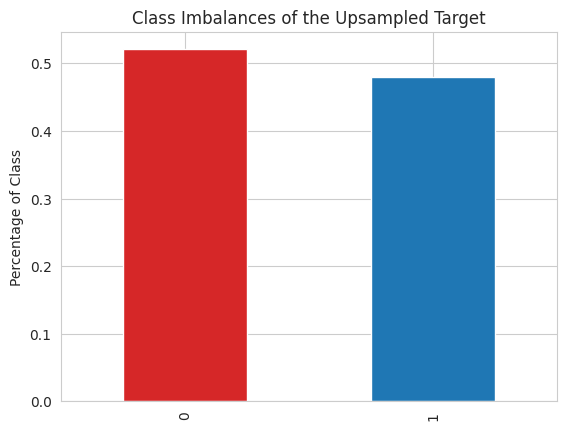

In [36]:
#re-examine class balances after upsampling
class_balance_upsampled = upsample_target_train.value_counts(normalize=True)
print('Balance of Classes:')
print(class_balance_upsampled)

fig, ax = plt.subplots()

bar_colors = ['tab:red', 'tab:blue']

class_balance_upsampled.plot.bar(ylabel='Percentage of Class', title='Class Imbalances of the Upsampled Target', color=bar_colors)


plt.show()

class imbalance is much closer to at 52% to 47%, enabeling us to move forward with our model training

# MOdel Training

In [37]:
#calculate auc-roc score
def auc_roc(model, features, target):
    probabilities_valid = model.predict_proba(features)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc = roc_auc_score(target, probabilities_one_valid)
    print('AUC - ROC Score:', auc_roc)
    
    fpr, tpr, thresholds = roc_curve(target, probabilities_one_valid)
    
    #calculate accuracy score on training set
    train_predictions = model.predict(features)
    train_accuracy = accuracy_score(target, train_predictions)
    print("Accuracy Score for the Training Set:", train_accuracy)
    
    #plot auc-roc curve
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.show()
    return

Dummy Classifier:

AUC - ROC Score: 0.5
Accuracy Score for the Training Set: 0.4996446339729922


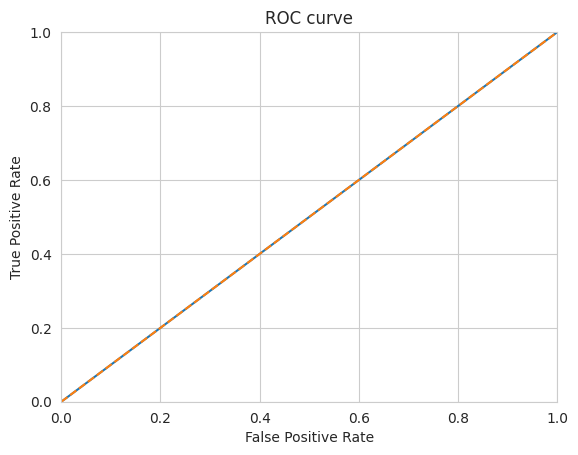

In [38]:
#initialize dummy model
dummy_clf = DummyClassifier(strategy='uniform') #strategy is uniform because data is now balanced
dummy_clf.fit(upsample_features_train, upsample_target_train) #fit the dummy classifier to upsampled training set
dummy_pred = dummy_clf.predict(features_valid)

print('Dummy Classifier:')
print('')

#evaluate the dummy model
auc_roc(dummy_clf, features_valid, target_valid)

AUC-ROC score of 0.5, the dummy classifer has no ability to seperate between the two classes.

**Logistic Regression**

In [39]:
%%time
#initialize the logistic regression model
lr = LogisticRegression(random_state=12345)

#parameter grid
lr_params = {
    'penalty' : ['l1', 'l2'],
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'newton-cholesky', 'sag', 'saga'],
    'fit_intercept': [True, False],
    'n_jobs': list(range(1,10))
}

lr_clf = GridSearchCV(lr, lr_params, scoring='roc_auc', n_jobs=-1, cv=2)
lr_clf.fit(upsample_features_train, upsample_target_train)

ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.